In [1]:
# load libraries
# install.packages("RColorBrewer")
# install.packages("maps")
# install.packages("mapproj")
# install.packages("openintro")
# install.packages("glmnet")
# install.packages('caTools')
# install.packages("ROCR")
# install.packages("MLmetrics")
library(caTools)
library(RColorBrewer)
library(ggplot2)
library(dplyr)
library(maps)
library(mapproj)
library(glmnet)
library(ROCR)
library(repr)
library(MLmetrics)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-16

Loading required package: gplots

Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess


Attaching package: ‘MLmetrics’

The following object is masked from ‘package:base’:

    Recall



In [2]:
# import data
setwd('~/Downloads/DataIncubator')     # set the working directory
data15=read.csv('marathon_results_2015.csv',header = TRUE, na.strings=c("","NA","-"),stringsAsFactors = F)
data16=read.csv('marathon_results_2016.csv',header = TRUE, na.strings=c("","NA", "-"),stringsAsFactors = F)
data17=read.csv('marathon_results_2017.csv',header = TRUE, na.strings=c("","NA", "-"),stringsAsFactors = F)

In [3]:
# Data cleaning and pre-process 
drops15 <- c("X","Citizen", "X.1", "Proj.Time")
data15 = data15[ , !(names(data15) %in% drops15)]  # drop unnecessary columns
drops16 <- c("Citizen", "X", "Proj.Time")
data16 = data16[ , !(names(data16) %in% drops16)]
drops17 <- c("X","Citizen", "X.1", "Proj.Time")
data17 = data17[ , !(names(data17) %in% drops17)]

# form age groups
# https://www.baa.org/races/boston-marathon/enter/qualify
data15$Age_group = findInterval(data15$Age, c(18, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80))
data16$Age_group = findInterval(data16$Age, c(18, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80))
data17$Age_group = findInterval(data17$Age, c(18, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80))

data15_c=data15[complete.cases(data15),]  # keep complete info 
data16_c=data16[complete.cases(data16),] 
data17_c=data17[complete.cases(data17),] 

# whether in the top 10% of their age division
age_15 = as.data.frame(xtabs(formula=~Age_group, data=data15))
data15_c = merge(data15_c, age_15, by="Age_group")
data15_c$class = data15_c$Division<=0.1*data15_c$Freq

age_16 = as.data.frame(xtabs(formula=~Age_group, data=data16))
data16_c = merge(data16_c, age_16, by="Age_group")
data16_c$class = data16_c$Division<=0.1*data16_c$Freq

age_17 = as.data.frame(xtabs(formula=~Age_group, data=data17))
data17_c = merge(data17_c, age_17, by="Age_group")
data17_c$class = data17_c$Division<=0.1*data17_c$Freq

data_c = rbind(data15_c, data16_c, data17_c) # combine datasets

# convert time to mininutes, function provided by TylerBaur: https://www.kaggle.com/tjbaur
timeinmins<-function(str){
  if (str!=""&& str!="-"){
    timestr<-strsplit(str,":")[[1]]
    time<-as.numeric(timestr[1])*60+as.numeric(timestr[2])+as.numeric(timestr[3])/60
    return(time)
  }
  else
    return(NA)
}

timenames<-c("X5K","X10K","X15K","X20K","Half","X25K","X30K","X35K","X40K","Pace","Official.Time")
for (i in timenames)
{
  data_c[[i]]=sapply(data_c[[i]],timeinmins)
}

data_USA = data_c[data_c$Country == 'USA',]


	Pearson's Chi-squared test

data:  age_gender_table
X-squared = 2908.6, df = 10, p-value < 2.2e-16


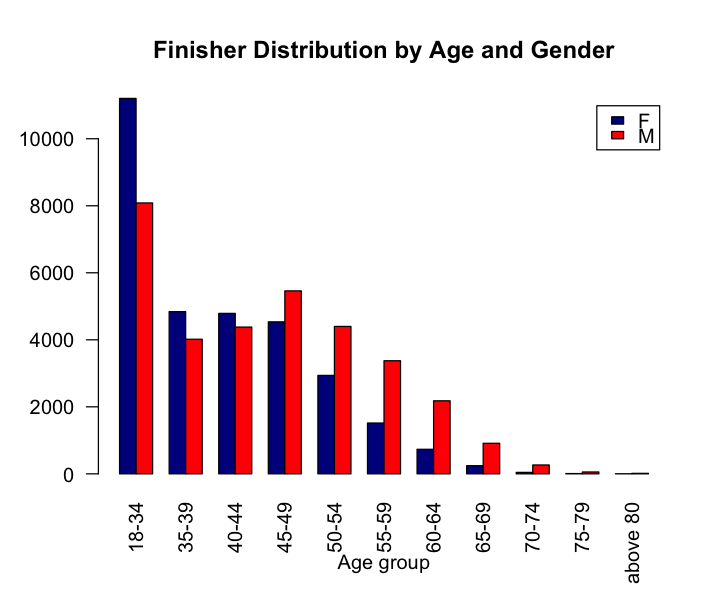

In [7]:
# Q1: association test between age and gender
age_gender_table = xtabs(formula=~M.F + Age_group, data=data_USA)
chisq.test(age_gender_table)

# generate barplot by gender and age
counts <- table(data_USA$M.F, data_USA$Age_group)
names = c("18-34", "35-39", "40-44", "45-49", "50-54", "55-59", "60-64", "65-69", "70-74", "75-79", "above 80")
options(repr.plot.width=6, repr.plot.height=5)
barplot(counts, names.arg = names, las = 2, main="Finisher Distribution by Age and Gender",
        xlab="Age group", col=c("darkblue","red"),
        legend = rownames(counts), beside=TRUE)

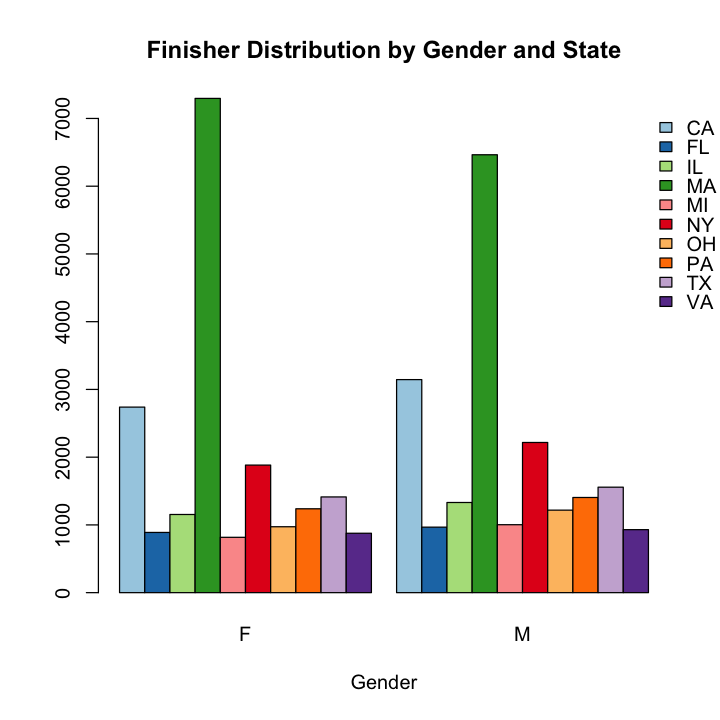

In [14]:
# top 10 states that have the most finishers
state_table = as.data.frame(xtabs(formula=~State, data=data_USA))
state_order = state_table[order(state_table$Freq, decreasing = TRUE),] # order by the number of participants in each state
top_10_state = as.character(state_order[1:10, 1])

# barplot for the top 10 states
color = grDevices::colors()[grep('gr(a|e)y', grDevices::colors(), invert = T)]
counts <- table(data_USA$State, data_USA$M.F)
counts_top_10 = counts[row.names(counts) %in% top_10_state,] 
options(repr.plot.width=6, repr.plot.height=6)
barplot(counts_top_10, main="Finisher Distribution by Gender and State",
        xlab="Gender", col = brewer.pal(nrow(counts_top_10), "Paired"), legend = rownames(counts_top_10), 
        args.legend = list(x = 24.8, bty = "n"), 
        beside=TRUE)


In [15]:
abbr2state <- function(abbr){
  ab    <- tolower(c("AL",
             "AK", "AZ", "KS", "UT", "CO", "CT",
             "DE", "FL", "GA", "HI", "ID", "IL",
             "IN", "IA", "AR", "KY", "LA", "ME",
             "MD", "MA", "MI", "MN", "MS", "MO",
             "MT", "NE", "NV", "NH", "NJ", "NM",
             "NY", "NC", "ND", "OH", "OK", "OR",
             "PA", "RI", "SC", "SD", "TN", "TX",
             "CA", "VT", "VA", "WA", "WV", "WI",
             "WY", "DC"))
  st    <- c("Alabama",
             "Alaska", "Arizona", "Kansas",
             "Utah", "Colorado", "Connecticut",
             "Delaware", "Florida", "Georgia",
             "Hawaii", "Idaho", "Illinois",
             "Indiana", "Iowa", "Arkansas",
             "Kentucky", "Louisiana", "Maine",
             "Maryland", "Massachusetts", "Michigan",
             "Minnesota", "Mississippi", "Missouri",
             "Montana", "Nebraska", "Nevada",
             "New Hampshire", "New Jersey", "New Mexico",
             "New York", "North Carolina", "North Dakota",
             "Ohio", "Oklahoma", "Oregon",
             "Pennsylvania", "Rhode Island", "South Carolina",
             "South Dakota", "Tennessee", "Texas",
             "California", "Vermont", "Virginia",
             "Washington", "West Virginia", "Wisconsin",
             "Wyoming", "District of Columbia")
  st[match(tolower(abbr), ab)]
}

Warning message:
“Ignoring unknown aesthetics: x, y”

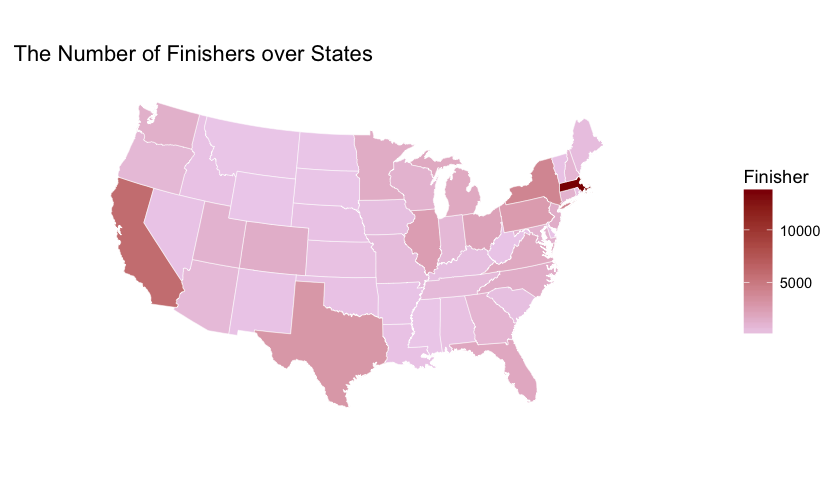

In [18]:
# distribution over states
# 1. the number of participants
colnames(state_table)[2] <- "Finisher"
us <- map_data("state")
gg <- ggplot()
gg <- gg + labs(x=NULL, y=NULL, title="The Number of Finishers over States")
gg <- gg + geom_map(data=us, map=us, aes(x=long, y=lat, map_id=region),
                    fill="#ffffff", color="#ffffff", size=0.15)
gg <- gg + geom_map(data=state_table, map=us,
                    aes(fill=Finisher, map_id=tolower(abbr2state(as.character(State)))),
                    color="#ffffff", size=0.15)
gg <- gg + scale_fill_continuous(low='thistle2', high='darkred', 
                                 guide='colorbar')
gg <- gg + coord_map("albers", lat0 = 39, lat1 = 45) 
gg <- gg + theme(panel.border = element_blank())
gg <- gg + theme(panel.background = element_blank())
gg <- gg + theme(axis.ticks = element_blank())
gg <- gg + theme(axis.text = element_blank())
options(repr.plot.width=7, repr.plot.height=4)
gg

Warning message:
“Ignoring unknown aesthetics: x, y”

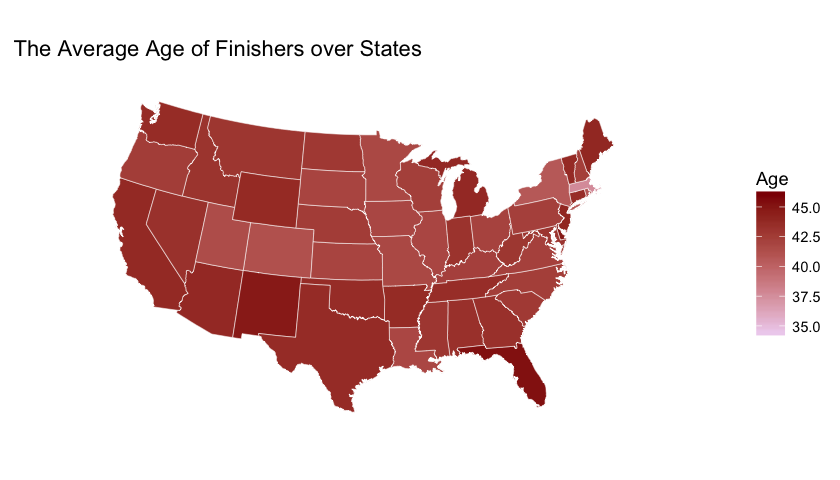

In [19]:
# 2. the average age
avg_age_state = aggregate(data_USA$Age, list(data_USA$State), mean)
colnames(avg_age_state)[1] <- "State"
colnames(avg_age_state)[2] <- "Age"
gg <- ggplot()
gg <- gg + geom_map(data=us, map=us, aes(x=long, y=lat, map_id=region),
                    fill="#ffffff", color="#ffffff", size=0.15)
gg <- gg + geom_map(data=avg_age_state, map=us,
                    aes(fill=Age, map_id=tolower(abbr2state(as.character(State)))),
                    color="#ffffff", size=0.15)
gg <- gg + scale_fill_continuous(low='thistle2', high='darkred', 
                                 guide='colorbar')
gg <- gg + labs(x=NULL, y=NULL, title="The Average Age of Finishers over States")
gg <- gg + coord_map("albers", lat0 = 39, lat1 = 45) 
gg <- gg + theme(panel.border = element_blank())
gg <- gg + theme(panel.background = element_blank())
gg <- gg + theme(axis.ticks = element_blank())
gg <- gg + theme(axis.text = element_blank())
options(repr.plot.width=7, repr.plot.height=4)
gg

Warning message:
“Ignoring unknown aesthetics: x, y”

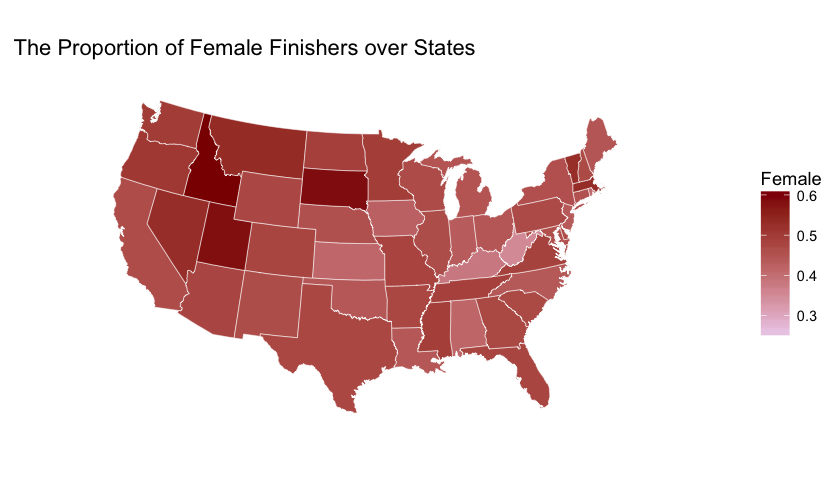

In [20]:
# 3. the proportion of female participants
data_USA$M.F[data_USA$M.F == "F"] = 1
data_USA$M.F[data_USA$M.F == "M"] = 0
data_USA$M.F = as.numeric(data_USA$M.F)
female_state = aggregate(data_USA$M.F, list(data_USA$State), mean)
colnames(female_state)[1] <- "State"
colnames(female_state)[2] <- "Female"
gg <- ggplot()
gg <- gg + geom_map(data=us, map=us, aes(x=long, y=lat, map_id=region),
                    fill="#ffffff", color="#ffffff", size=0.15)
gg <- gg + geom_map(data=female_state, map=us,
                    aes(fill=Female, map_id=tolower(abbr2state(as.character(State)))),
                    color="#ffffff", size=0.15)
gg <- gg + scale_fill_continuous(low='thistle2', high='darkred', 
                                 guide='colorbar')
gg <- gg + labs(x=NULL, y=NULL, title = "The Proportion of Female Finishers over States")
gg <- gg + coord_map("albers", lat0 = 39, lat1 = 45) 
gg <- gg + theme(panel.border = element_blank())
gg <- gg + theme(panel.background = element_blank())
gg <- gg + theme(axis.ticks = element_blank())
gg <- gg + theme(axis.text = element_blank())
options(repr.plot.width=7, repr.plot.height=4)
gg

Warning message:
“Ignoring unknown aesthetics: x, y”

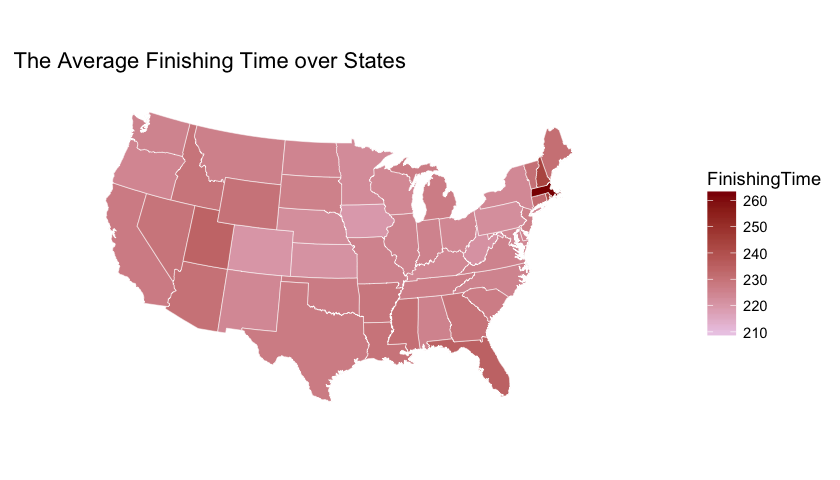

In [21]:
# 4. the average finishing time
avg_time_state = aggregate(data_USA$Official.Time, list(data_USA$State), mean)
colnames(avg_time_state)[1] <- "State"
colnames(avg_time_state)[2] <- "FinishingTime"
gg <- ggplot()
gg <- gg + geom_map(data=us, map=us, aes(x=long, y=lat, map_id=region),
                    fill="#ffffff", color="#ffffff", size=0.15)
gg <- gg + geom_map(data=avg_time_state, map=us,
                    aes(fill=FinishingTime, map_id=tolower(abbr2state(as.character(State)))),
                    color="#ffffff", size=0.15)
gg <- gg + scale_fill_continuous(low='thistle2', high='darkred', 
                                 guide='colorbar')
gg <- gg + labs(x=NULL, y=NULL, title = "The Average Finishing Time over States")
gg <- gg + coord_map("albers", lat0 = 39, lat1 = 45) 
gg <- gg + theme(panel.border = element_blank())
gg <- gg + theme(panel.background = element_blank())
gg <- gg + theme(axis.ticks = element_blank())
gg <- gg + theme(axis.text = element_blank())
options(repr.plot.width=7, repr.plot.height=4)
gg

Warning message:
“Ignoring unknown aesthetics: x, y”

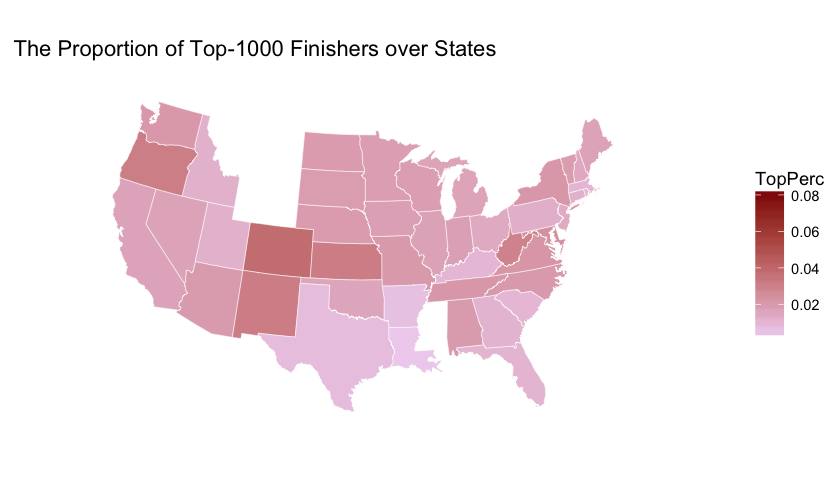

In [22]:
# 5. distribution of top 1000 finisher (percentage)
data_USA_order = data_USA[order(data_USA$Official.Time),]
data_USA_order_top = data_USA_order[1:1000,]
top_state = as.data.frame(xtabs(formula=~State, data=data_USA_order_top))
colnames(top_state)[2] <- "TopFinishers"
top_state$TopPerc = top_state$TopFinishers/state_table$Finisher[state_table$State %in% top_state$State]
gg <- ggplot()
gg <- gg + geom_map(data=us, map=us, aes(x=long, y=lat, map_id=region),
                    fill="#ffffff", color="#ffffff", size=0.15)
gg <- gg + geom_map(data=top_state, map=us,
                    aes(fill=TopPerc, map_id=tolower(abbr2state(as.character(State)))),
                    color="#ffffff", size=0.15)
gg <- gg + scale_fill_continuous(low='thistle2', high='darkred', 
                                 guide='colorbar')
gg <- gg + labs(x=NULL, y=NULL, title = "The Proportion of Top-1000 Finishers over States")
gg <- gg + coord_map("albers", lat0 = 39, lat1 = 45) 
gg <- gg + theme(panel.border = element_blank())
gg <- gg + theme(panel.background = element_blank())
gg <- gg + theme(axis.ticks = element_blank())
gg <- gg + theme(axis.text = element_blank())
options(repr.plot.width=7, repr.plot.height=4)
gg

In [23]:
# Q2: predict the finish time for US runners (81%)
# linear regression
# create dummy for factors
y = data_USA$Official.Time
X = cbind(data_USA$Age, data_USA$M.F, data_USA$X5K, data_USA$X10K)
Xs =  scale(X)  # standardize predictors
n=dim(data_USA)[1]
iter = 10
p=0.8
grid=10^seq(4,-4,length=100)

mse_lasso = rep(0, iter)
r2_lasso = rep(0, iter)

mse_ridge = rep(0, iter)
r2_ridge = rep(0, iter)

mse_linear = rep(0, iter)
r2_linear = rep(0, iter)

for (i in 1:iter)
{
  train=sample(n,floor(n*p))
  test=(-train)
  
  # linear regression
  train_set = as.data.frame(cbind(Xs[train,], y[train]))
  l1 <- lm(V5 ~., data=train_set)
  new.df <- as.data.frame(Xs[test,])
  l1.pred = predict(l1, new.df)
  mse_linear[i]=mean((l1.pred-y[test])^2)
  r2_linear[i]=1-(mse_linear[i]*length(y[test]))/(var(y[test])*(length(y[test])-1))
  
  
  # lasso
  cv.out=cv.glmnet(Xs[train,],y[train],alpha=1)
  bestlam=cv.out$lambda.min
  lasso.best=glmnet(Xs[train,],y[train],alpha=1,lambda=bestlam)
  lasso.pred=predict(lasso.best,newx=Xs[test,])
  mse_lasso[i]=mean((lasso.pred-y[test])^2)
  r2_lasso[i]=1-(mse_lasso[i]*length(y[test]))/(var(y[test])*(length(y[test])-1))
  
  # ridge
  cv.out=cv.glmnet(Xs[train,],y[train],alpha=0)
  bestlam=cv.out$lambda.min
  ridge.best=glmnet(Xs[train,],y[train],alpha=0,lambda=bestlam)
  ridge.pred=predict(ridge.best,newx=Xs[test,])
  mse_ridge[i]=mean((ridge.pred-y[test])^2)
  r2_ridge[i]=1-(mse_ridge[i]*length(y[test]))/(var(y[test])*(length(y[test])-1))
}

[1] "Linear regression MSE 248.487385295263"
[1] "Lasso MSE 248.759427388754"
[1] "Ridge MSE 309.242348818642"


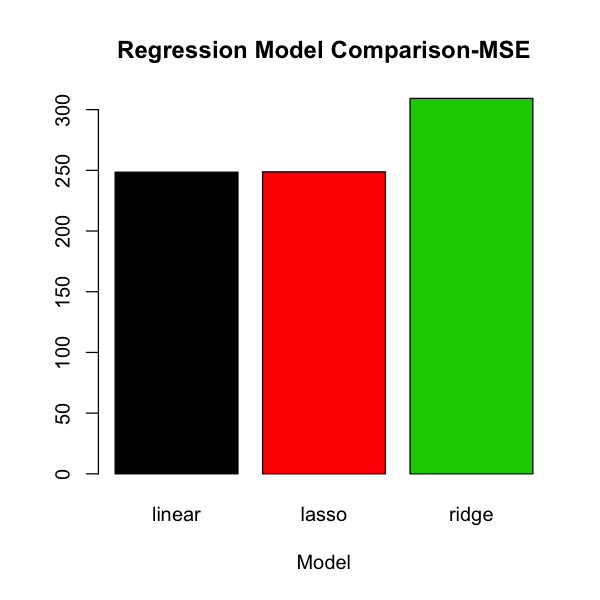

In [27]:
# Model comparison
metrics = matrix(c(mean(mse_linear), mean(mse_lasso), mean(mse_ridge), mean(r2_linear), mean(r2_lasso),
                   mean(r2_ridge)), nrow = 3)
row.names(metrics) = c("linear", "lasso", "ridge")
colnames(metrics) = c("MSE", "R2")
mse = metrics[,1]
r2 = metrics[,2]
options(repr.plot.width=5, repr.plot.height=5)
barplot(mse, main="Regression Model Comparison-MSE",
        xlab="Model", col = 1:3,  
        beside=TRUE)
print(paste('Linear regression MSE',mean(mse_linear)))
print(paste('Lasso MSE',mean(mse_lasso)))
print(paste('Ridge MSE',mean(mse_ridge)))

[1] "Linear regression R square 0.858706742959393"
[1] "Lasso R square 0.858551968418776"
[1] "Ridge R square 0.824171949278229"


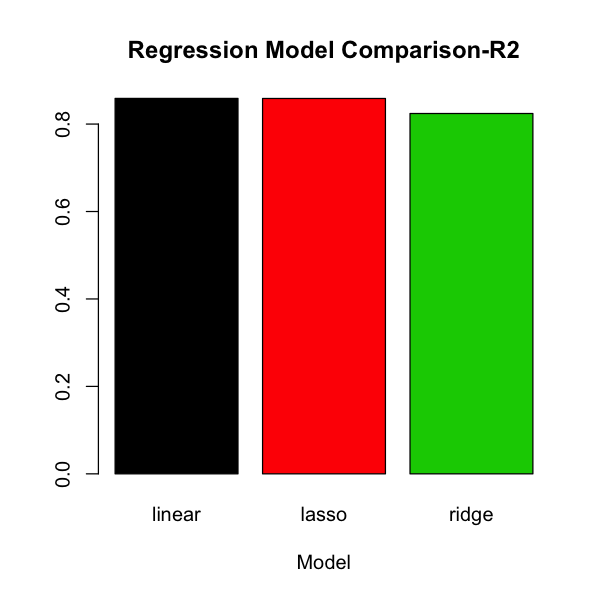

In [28]:
options(repr.plot.width=5, repr.plot.height=5)
barplot(r2, main="Regression Model Comparison-R2",
        xlab="Model", col = 1:3,  
        beside=TRUE)
print(paste('Linear regression R square',mean(r2_linear)))
print(paste('Lasso R square',mean(r2_lasso)))
print(paste('Ridge R square',mean(r2_ridge)))

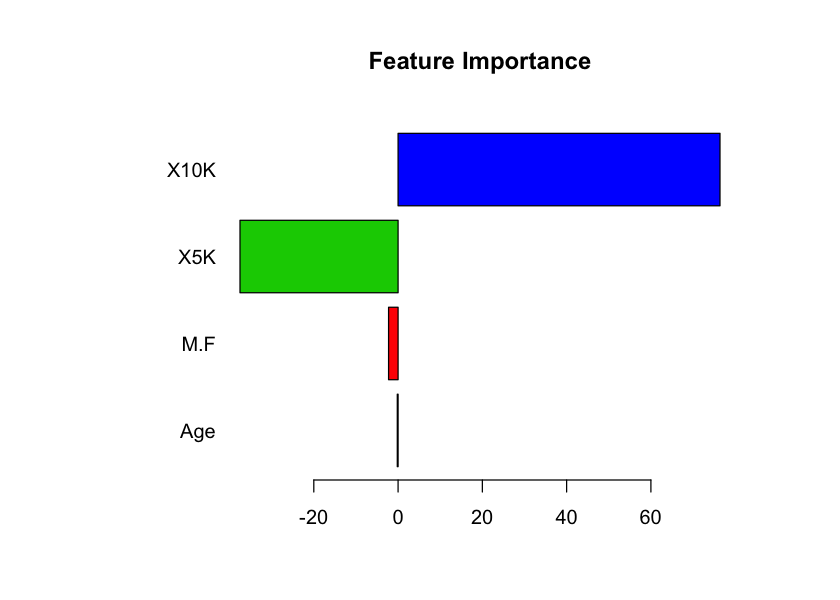

In [29]:
# feature importance from linear regression
c = l1$coefficients[-1]
par(mai=c(1,2,1,1))
names = c("Age", "M.F", "X5K", "X10K")
options(repr.plot.width=7, repr.plot.height=5)
barplot(c,main="Feature Importance", horiz=TRUE,names.arg=names,las=1, col = 1:4)

In [30]:
# Q3: predict ranking (whether top 10 in their age division)
data_log = as.data.frame(cbind(Xs, data_USA$class))
set.seed(88)
train=sample(n,floor(n*p))
test=(-train)
train_log <- data_log[train,]
test_log <- data_log[test,]
#logistic regression model
model <- glm(V5 ~. , data = train_log, family = binomial(link='logit'))
summary(model)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


Call:
glm(formula = V5 ~ ., family = binomial(link = "logit"), data = train_log)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.9955  -0.3946  -0.1372  -0.0019   4.4428  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -4.74073    0.04694 -101.00   <2e-16 ***
V1            2.57835    0.03403   75.77   <2e-16 ***
V2            2.50369    0.03223   77.69   <2e-16 ***
V3            5.13307    0.22888   22.43   <2e-16 ***
V4          -10.83806    0.25131  -43.13   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 44498  on 51199  degrees of freedom
Residual deviance: 24190  on 51195  degrees of freedom
AIC: 24200

Number of Fisher Scoring iterations: 7


In [31]:
predict <- predict(model, newdata = test_log[,-ncol(test_log)], type = 'response')
fitted.results = ifelse(predict>0.5, 1, 0)

misClasificError <- mean(fitted.results != test_log$V5)
print(paste('Accuracy',1-misClasificError))

[1] "Accuracy 0.890242949769549"


In [32]:
#confusion matrix
table(test_log$V5, predict > 0.5)

   
    FALSE  TRUE
  0 10331   392
  1  1013  1065

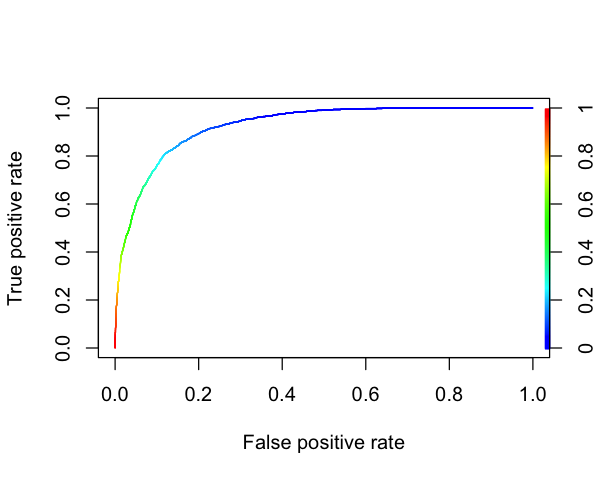

In [37]:
#ROCR Curve
ROCRpred <- prediction(predict, test_log$V5)
ROCRperf <- performance(ROCRpred, 'tpr','fpr')
options(repr.plot.width=5, repr.plot.height=4)
plot(ROCRperf, colorize = TRUE, text.adj = c(-0.2,1.7))

In [38]:
auc <- performance(ROCRpred, measure = "auc")
auc <- auc@y.values[[1]]
auc

[1] 0.9257183